<a href="https://colab.research.google.com/github/tikendraw/language-translation-model/blob/main/language_translation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translation Model (English to Hindi)


---




In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/language-translation-model.git 
    os.chdir('language-translation-model') 
    print(os.getcwd())

In [2]:
# Dependencies
import pandas as pd
# ! pip install polars -q
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tensorflow_hub
# import tensorflow_hub as hub
import os
import re
import json
from sklearn.model_selection import train_test_split

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)


2023-02-15 15:50:22.130965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:50:22.670051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 15:50:22.670107: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 15:50:24.072637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Tf version:  2.11.0
GPU:  0


2023-02-15 15:50:26.437219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 15:50:26.437445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 15:50:26.437521: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-15 15:50:26.437584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-15 15:50:26.437643: W tensorflow/c

In [3]:
dataset_url = 'http://www.manythings.org/anki/hin-eng.zip'

In [4]:
# # Download the dataset
if 'google.colab' in sys.modules:
    # donwload
    !wget $dataset_url -P dataset

    # # Unzip the downloaded file
    !unzip ./dataset/hin-eng.zip -d ./dataset

    # # Show size
    !du -h  ./dataset

# Reading the data

In [5]:
# !pip install polars -q
import polars as pd

In [6]:
df = pd.read_csv('./dataset/hin.txt', sep = '\t', new_columns = ['english', 'hindi', 'somethingelse'])[['english','hindi']]

In [7]:
df.shape

(2908, 2)

In [8]:
df.sample(10)

english,hindi
str,str
"""It may not be ...","""शायद हमें उस म..."
"""Tom doesn't kn...","""टॉम अभी तक नही..."
"""This medicine ...","""यह दवाई दर्द क..."
"""Please turn on...","""टीवी चालू कीजि..."
"""I had met her ...","""मैं उससे पहले ..."
"""The government...","""सरकार शिक्षा क..."
"""Can I give you...","""क्या मैं तुम्ह..."
"""We're against ...","""हम जंग के ख़िल..."
"""He was buried ...","""उसको इस कब्रिस..."


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
UNITS = 32
EMBEDDING_DIMS = 16
BATCH_SIZE = 32

# Prepare the data `tf.data`

In [11]:
# Split the data for train and val
train_df, val_df = train_test_split(df, test_size = .02, random_state = 4 )

In [12]:
print('train shape: ', train_df.shape)
print('val shape: ', val_df.shape)

train shape:  (2849, 2)
val shape:  (59, 2)


In [13]:
BUFFER_SIZE = 2000

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['english'].to_list(), train_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['english'].to_list(), val_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-02-15 15:50:26.571642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:

# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    # text = tf.text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text



# preprocessing text
def tf_lower_and_split_punct_hi(text):
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [16]:
some_hindi_text = 'उन्होंने मेरी का| मज़ाक उड़ाया'
print(some_hindi_text)
b= tf_lower_and_split_punct_hi(some_hindi_text)
print(b)
print(b.numpy().decode())
del(b)

उन्होंने मेरी का| मज़ाक उड़ाया
tf.Tensor(b'[START] \xe0\xa4\x89\xe0\xa4\xa8\xe0\xa5\x8d\xe0\xa4\xb9\xe0\xa5\x8b\xe0\xa4\x82\xe0\xa4\xa8\xe0\xa5\x87 \xe0\xa4\xae\xe0\xa5\x87\xe0\xa4\xb0\xe0\xa5\x80 \xe0\xa4\x95\xe0\xa4\xbe |  \xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\x95 \xe0\xa4\x89\xe0\xa4\xa1\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\xaf\xe0\xa4\xbe [END]', shape=(), dtype=string)
[START] उन्होंने मेरी का |  मज़ाक उड़ाया [END]


In [17]:
for i, j in train_ds.take(1):
    print('i: ',i)
    print('j: ', j)
    # print('j decoded: ',j.numpy().decode())

i:  tf.Tensor(
[b'You reap what you sow.' b'Can I use your pencil?'
 b'Glass is made from sand.' b'Tom is strict with his children.'
 b'The doctor advised him not to smoke.' b'She is very pretty.'
 b'He wanted to succeed.'
 b'You should not speak ill of others behind their backs.'
 b'Tom handed the list to Mary.' b'I met Mary yesterday.'
 b'You look nice in that dress.' b'Happy New Year!'
 b'Excuse me, is there a toilet nearby?'
 b'There is a strange man at the door.'
 b'A rubber ball bounces because it is elastic.'
 b'The storm destroyed the whole town.' b'Help!'
 b"I've taught myself to play the guitar." b'Smog causes plants to die.'
 b'The mountain is covered with snow.' b"I'm alone."
 b'Your dog is very fat.'
 b'They were about to leave when I arrived there.'
 b'This story is worth reading again.'
 b'I doubt the truth of his statement.' b'The patient breathed his last.'
 b'I am fully convinced of your innocence.'
 b'India gained independence from Britain in 1947.'
 b'This is why I 

# Text Vectorization


In [18]:
output_sequence_length = 200

In [19]:
eng_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_en, output_sequence_length= output_sequence_length)
hin_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_hi, output_sequence_length= output_sequence_length )

In [20]:
# Adapting to textvectorizer
eng_vectorizer.adapt(train_ds.map(lambda x, y: x))
hin_vectorizer.adapt(train_ds.map(lambda x, y: y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
max_token_english = len(eng_vectorizer.get_vocabulary())
max_token_hindi = len(hin_vectorizer.get_vocabulary())

print('Maxtokens:')
print( 'English : ', max_token_english)
print('Hindi: ', max_token_hindi)

Maxtokens:
English :  2359
Hindi:  3016


In [22]:
print('Text: ',some_hindi_text)
print('\nEncoded text: ,')
hin_vectorizer(some_hindi_text)

Text:  उन्होंने मेरी का| मज़ाक उड़ाया

Encoded text: ,


<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([   2,  173,   40,   20, 1446,  369,    1,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

## Mapping Vectorizer to dataset

In [23]:
BATCH_SIZE = 32

In [24]:
def make_vec(x, y ):
    x, y = eng_vectorizer(x), hin_vectorizer(y)

    y_in = y[:,:-1]
    y_out = y[:,1:]
    return (x,y_in), y_out

In [25]:
train_ds = train_ds.map(make_vec) #.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(make_vec) # .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
for i,j in train_ds.take(1):
    print(i[1])
    print()
    print(j)
    break

tf.Tensor(
[[   2   59   13 ...    0    0    0]
 [   2  173  505 ...    0    0    0]
 [   2    9  846 ...    0    0    0]
 ...
 [   2  442 1970 ...    0    0    0]
 [   2   12 2733 ...    0    0    0]
 [   2    8 1279 ...    0    0    0]], shape=(32, 199), dtype=int64)

tf.Tensor(
[[  59   13   11 ...    0    0    0]
 [ 173  505   19 ...    0    0    0]
 [   9  846   13 ...    0    0    0]
 ...
 [ 442 1970   15 ...    0    0    0]
 [  12 2733   14 ...    0    0    0]
 [   8 1279  327 ...    0    0    0]], shape=(32, 199), dtype=int64)


# Model

## Encoder

In [103]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts)
        context = self(context)
        return context

## Attention

In [48]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## Decoder

In [49]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Decoder call

In [50]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  

    # 1. Lookup the embeddings
    x = self.embedding(x)

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights


    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)

    if return_state:
        return logits, state
    else:
        return logits

In [51]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [52]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [53]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [110]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder
        

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [111]:
model = Translator(UNITS, eng_vectorizer, hin_vectorizer)

In [112]:
model

In [113]:
sample = train_df.sample(5)
some_hindi_text = sample['hindi'].to_numpy()
some_eng_text = sample['english'].to_numpy()

In [114]:
print(some_hindi_text)
print(some_eng_text)

['हम वहाँ तीन बार खा चुके हैं।' 'हम कल शायद नहीं जीतेंगे।'
 'तुम दो तीन दिनों में फिरसे ठीक हो जाओगी।'
 'फ़ोटोकॉपियर में कागज़ खतम हो गया है।'
 'मैं उससे कल दोपहर को मिलना चाहता हूँ।']
['We have eaten there three times.' 'We may not win tomorrow.'
 "You'll be all right again in a couple of days."
 "We've run out of paper for the photocopier."
 "I'd like to see him tomorrow afternoon."]


In [115]:
vectorized_eng_text = eng_vectorizer(some_eng_text)
vectorized_eng_text[:,:10]

<tf.Tensor: shape=(5, 10), dtype=int64, numpy=
array([[   2,   30,   18,  855,   50,  190,  222,    4,    3,    0],
       [   2,   30,  131,   39,  696,   93,    4,    3,    0,    0],
       [   2,  349,   41,   51,  170,  133,   14,   10,  866,   13],
       [   2,  701,  582,   69,   13, 1052,   25,    5, 1653,    4],
       [   2,  228,   35,    7,   94,   36,   93,  457,    4,    3]])>

In [116]:
vectorized_hindi_text = hin_vectorizer(some_hindi_text)
vectorized_hindi_text[:,:10]

<tf.Tensor: shape=(5, 10), dtype=int64, numpy=
array([[   2,   46,  154,  164,  143,  949,  486,   17,    3,    0],
       [   2,   46,   50,  364,    7, 2464,    3,    0,    0,    0],
       [   2,   23,  115,  164,  379,    6,  225,  200,   18, 2485],
       [   2, 2069,    6, 2759,  212,   18,   68,    4,    3,    0],
       [   2,    8,  107,   50,  332,   15,  297,  102,   24,    3]])>

In [117]:
vec_hindi_in = vectorized_hindi_text[:,:-1]
vec_hindi_out = vectorized_hindi_text[:,1:]
print(vec_hindi_in[:,:10])
print()
print(vec_hindi_out[:,:10])

tf.Tensor(
[[   2   46  154  164  143  949  486   17    3    0]
 [   2   46   50  364    7 2464    3    0    0    0]
 [   2   23  115  164  379    6  225  200   18 2485]
 [   2 2069    6 2759  212   18   68    4    3    0]
 [   2    8  107   50  332   15  297  102   24    3]], shape=(5, 10), dtype=int64)

tf.Tensor(
[[  46  154  164  143  949  486   17    3    0    0]
 [  46   50  364    7 2464    3    0    0    0    0]
 [  23  115  164  379    6  225  200   18 2485    3]
 [2069    6 2759  212   18   68    4    3    0    0]
 [   8  107   50  332   15  297  102   24    3    0]], shape=(5, 10), dtype=int64)


In [118]:
encoder = Encoder(eng_vectorizer, UNITS)
# context_eng = encoder((vectorized_eng_text))

In [119]:
new_tx = encoder.convert_input(['hey man'])

In [120]:
# context_eng

In [121]:
# decoder = Decoder(hin_vectorizer, UNITS)
# logits = decoder(context_eng, vec_hindi_in)
# logits.shape

In [132]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [133]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [134]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [182]:
EPOCHS = 200
CKPT_DIR = './model_checkpoint'

In [156]:
from datetime import datetime

In [179]:
import os

In [181]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR,  f"{datetime.now().strftime('%m:%d:%Y, %H:%M:%S')}_accuracy:{max(history.history['masked_acc']):.3f}"),
    monitor= 'loss',
    verbose= 0,
    save_best_only = True,
    save_weights_only = True,
    mode= 'auto',
    save_freq='epoch'
)

In [183]:
history = model.fit(
    train_ds.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = 50,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
    model_ckpt])

Epoch 1/2
50/50 [==============================] - 25s 505ms/step - loss: 0.0589 - masked_acc: 0.9841 - masked_loss: 0.0589 - val_loss: 8.0981 - val_masked_acc: 0.3695 - val_masked_loss: 8.2386
Epoch 2/2
50/50 [==============================] - 17s 349ms/step - loss: 0.0653 - masked_acc: 0.9812 - masked_loss: 0.0641


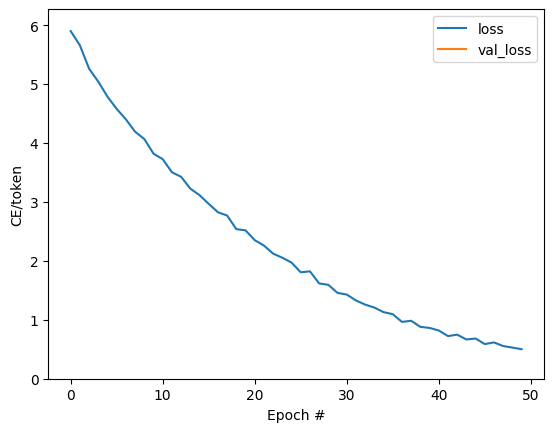

In [136]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

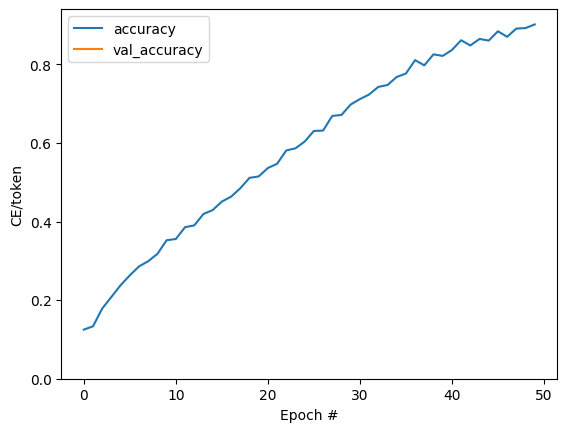

In [137]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [138]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [153]:
result = model.translate(['She loves me']) 
result[0].numpy().decode()

'उसने मुझसे मुझे देखा है। '

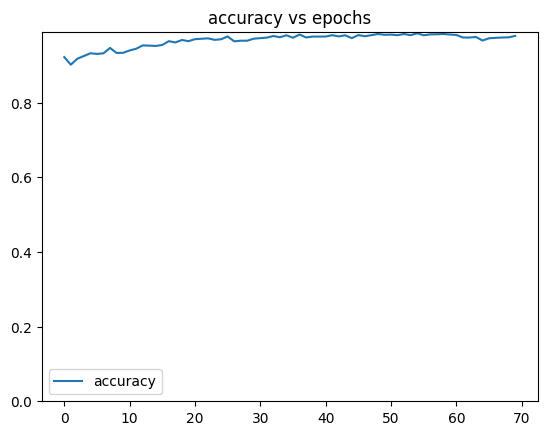

In [154]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.ylim([0, max(plt.ylim())])
plt.title('accuracy vs epochs')
plt.legend()